In [7]:
# Numpy and Pandas
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from numpy import mean
from numpy import std
import time
# Iterative Stratification untuk cross validation multilabel
from skmultilearn.model_selection import IterativeStratification
#Import Tensorflow dan extension
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Activation
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.callbacks import  EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.backend import sigmoid
from tensorflow.keras.optimizers import Adam, Nadam, Adagrad, SGD, RMSprop, Adadelta
import xgboost as xgb
#Import keras tuner dan metrics untuk tuning parameter
import kerastuner as kt
from kerastuner.tuners import RandomSearch, BayesianOptimization, Sklearn
from sklearn import metrics
import tensorflow_addons as tfa

#
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import average_precision_score

In [8]:
#Modifikasi IterativeStratification agar hasil random data tetap sama

def new_init(self, n_splits=3, order=1, sample_distribution_per_fold = None, random_state=None):

                  self.order = order
                  if random_state is not None:
                      do_shuffle = True
                  else:
                      do_shuffle = False
                  super(
                      IterativeStratification,
                      self).__init__(n_splits,
                                     shuffle=do_shuffle,
                                     random_state=random_state)
                  if sample_distribution_per_fold:
                      self.percentage_per_fold = sample_distribution_per_fold
                  else:
                      self.percentage_per_fold = [1 / float(self.n_splits) for _ in range(self.n_splits)]
    
IterativeStratification.__init__ = new_init

# AAC AAC

In [2]:
dataset = pd.read_csv('E:/temp/feature_2_aac.csv')

In [9]:
X_pepi=dataset.drop(['pdb_chain','Uniprot_chain','class'],axis=1)

In [4]:
Y=dataset['class']

In [10]:
#Fungsi model SAE
def sae_model(xt, xv = None, EPOCHS = 100,BATCH_SIZE = 32, opt = "adam",
              hl_node = 1024, lr = 0.01,af = "relu",num_layers = 3, do=0.5, fr_node = 0.5,
              verbose = 0,return_fe = False):
  #Setting result placeholders
  xt_ae = [] ;xv_ae = [] ; w_ae = []
  #If validation set is not present, use train set as validation set
  if xv is None :
    xv = xt.copy()
  opt = tf.keras.optimizers.get(opt) #Set optimizer
  K.set_value(opt.learning_rate, lr) #Set learning rate

  #Stacked Autoencoder architecture
  for n_layers in range(num_layers):
    #Autoencoder
    inp = Input(shape=(xt.shape[1],))
    #Apply Dropout
    hidden_layer = Dropout(do)(inp)
    #Layer encoder (jumlah layer sesuai dengan n_layers)
    enc = Dense(int(hl_node*(fr_node**n_layers)), activation = af)(hidden_layer)  
    #Layer Decoder
    dec = Dense(xt.shape[1],activation="linear")(enc)
    ae = Model(inp, dec)
    #Compile model
    ae.compile(optimizer=opt, loss='mean_squared_error')
    #EarlyStop jika sudah konvergen 
    es = EarlyStopping(monitor='val_loss', patience=15, verbose=verbose)
    #Latih model
    ae.fit(xt, xt, 
           epochs=EPOCHS,batch_size=BATCH_SIZE, 
           shuffle=True, callbacks = [es] , verbose = verbose,
           validation_data = (xv,xv))
    #Ekstrak Feature extraction
    fe = Model(ae.input, enc)
    #Simpan data hasil latih
    xt = fe.predict(xt) ; xt_ae.append(xt)
    xv = fe.predict(xv) ; xv_ae.append(xv)
    #Simpan bobot hasil latih SAE
    w_ae.append([layer_name for layer_name in ae.layers if "dense" in layer_name.name][0].get_weights())
    if verbose:
      print("Layer {} trained".format(n_layers+1))

  return (w_ae,xv) if return_fe else w_ae

In [11]:
#Fungsi DNN
def dnn_model(xt, n_outputs = 1, sae_weights = None, EPOCHS = 100,BATCH_SIZE = 32, opt = "adam",
              hl_node = 1024, lr = 0.01,af = "relu",num_layers = 3, do=0.5, fr_node = 0.5):
  opt = tf.keras.optimizers.get(opt) #Set optimizer
  K.set_value(opt.learning_rate, lr) #Set learning rate
  
  #Model architecture
  input_layer = Input(shape=(xt.shape[1],))
  hidden_layer = BatchNormalization()(input_layer)
  hidden_layer = Dropout(do)(hidden_layer)
#Set jumlah hidden layer
  for n_layers in range(num_layers):
    hidden_layer = Dense(int(hl_node*(fr_node**n_layers)), activation = af)(hidden_layer)
    hidden_layer = BatchNormalization()(hidden_layer)
    hidden_layer = Dropout(do)(hidden_layer)
  output_layer = Dense(n_outputs, activation = 'sigmoid')(hidden_layer)
#latih model
  dnn = Model(input_layer, output_layer)

  #Latih model DNN dengan bobot SAE (jika bobot ada)
  if sae_weights is not None:
    weights = sae_weights
    dnn_dense = [layer_name for layer_name in dnn.layers if "dense" in layer_name.name]
    for weight_from,weight_to in list(zip(weights,dnn_dense)):
      weight_to.set_weights(weight_from)

  #Compile model
  dnn.compile(optimizer=opt, loss='binary_crossentropy', metrics = [
               tf.keras.metrics.Precision(),
               tf.keras.metrics.Recall()],
               )
  return dnn

In [15]:
#Train SAE-DNN
#Variabel untuk simpan hasil
res_all = [[],[],[],[],[]]
auc_plots = []
#Latih SAE 
print("finding sae weights....")
ti0 = time.time()
# sae_weights = sae_model(xt = X_pepi)
ti1 = time.time()
print('done, processing time:', ti1-ti0)
i=0
t0 = time.time()
#Inisialisasi CV
np.random.seed(123)
cv = StratifiedKFold(n_splits=5, random_state=42,shuffle=True)
#Mulai latih DNN dengan bobot hasil SAE untuk tiap CV
for train_ix, test_ix in cv.split(X_pepi,Y):
    #Bagi data menjadi train, test
    X_train, X_test = X_pepi.iloc[train_ix,:], X_pepi.iloc[test_ix,:]
    y_train, y_test = Y[train_ix], Y[test_ix]  
    # define model dengan bobot SAE. Jika tidak memakai bobot SAE, sae_weights = None
    model = dnn_model(xt = X_train, sae_weights = sae_weights)
    # latih model
    model.fit(X_train, y_train, verbose=False, epochs=100)
    # Prediksi test 
    yhat = model.predict(X_test)
    # Bulatkan hasil prediksi (probabilitas)
    yhat = yhat.round()
    # Hitung metrik
    #Calculate metrics
    accu = accuracy_score(y_test, yhat)
    auc = roc_auc_score(y_test, yhat)
    precision_score,recall_score, f1_score,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=1)
    _,speci,_,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=0)
    
    res_all[0].append(accu);res_all[1].append(recall_score);res_all[2].append(precision_score);res_all[3].append(auc);res_all[4].append(f1_score)
    fpr, tpr, _ = roc_curve(y_test,  yhat)
    auc_plots.append([fpr,tpr,auc])
 
#Average and Stdv of k-fold CV
print('Average Result of {} CV'.format(5))
print('Accuracy    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[0]), np.std(res_all[0])))
print('Recall      : {0:.5f}±{1:.3f}'.format(np.mean(res_all[1]), np.std(res_all[1])))
print('Precision   : {0:.5f}±{1:.3f}'.format(np.mean(res_all[2]), np.std(res_all[2])))
print('ROC-AUC     : {0:.5f}±{1:.3f}'.format(np.mean(res_all[3]), np.std(res_all[3])))
print('F1 Score    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[4]), np.std(res_all[4])))
print(confusion_matrix(y_test,yhat))
print('===================================')

#Choose auc plot with highest score
best_auc_pubchem_aac = auc_plots[np.array(res_all[3]).argmax()]
res_all_pubchem_aac = res_all

#save model
model.save("SAE-DNN PubChem Biner pepi.h5")
        

finding sae weights....
done, processing time: 0.0
Average Result of 5 CV
Accuracy    : 0.81132±0.002
Recall      : 0.04578±0.013
Precision   : 0.81537±0.031
ROC-AUC     : 0.52163±0.006
F1 Score    : 0.08636±0.023
[[6970   19]
 [1601   98]]


In [ ]:
print('===================================')
print('SAE-DNN PERFORMANCE')
print('Accuracy    : {0:.5f}±{1:.3f}'.format(np.mean(acc_results), np.std(acc_results)))
print('F1 Score    : {0:.5f}±{1:.3f}'.format(np.mean(f1_results), np.std(f1_results)))
print('Precision   : {0:.5f}±{1:.3f}'.format(np.mean(prec_results), np.std(prec_results)))
print('Recall      : {0:.5f}±{1:.3f}'.format(np.mean(rec_results), np.std(rec_results)))
print('===================================')


## Tune Parameter

In [20]:
#Tune Parameter for RF
from sklearn.metrics import make_scorer
# number of trees 
n_estimators = [int(x) for x in np.linspace(100,500,5)]
#max depth
colsample_bytree = [x for x in np.linspace(0.1,1,10)]
#Learning rate
eta = [x for x in np.linspace(0.1,1,10)]
# create  grid
# define search space
params = dict()
params['n_estimators'] = [int(x) for x in np.linspace(100,500,5)]
params['colsample_bytree'] = colsample_bytree
params['eta'] = eta

# define evaluation
cv = StratifiedKFold(n_splits=5, random_state=42,shuffle=True)

t0 = time.time()
# Bayes search of parameters
xg_tune = BayesSearchCV(estimator=xgbc, search_spaces=params, n_jobs=-1, cv=cv, scoring = 'f1')
# Fit the model
xg_tune.fit(X_res, y_res)
t1 = time.time()
print("waktu proses", t1-t0)
# print results
print(xg_tune.best_params_)
print(xg_tune.best_score_)

D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:14:47] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
waktu proses 3480.4397196769714
OrderedDict([('colsample_bytree', 1.0), ('eta', 0.5), ('n_estimators', 400)])
0.8544952022769362


In [9]:
#XGB Baseline
res_all = [[],[],[],[],[]]
auc_plots = []

cv = StratifiedKFold(n_splits=5, random_state=42,shuffle=True)
for train_ind, test_ind in cv.split(X_res, y_res):
  #Train the model
  X_train,y_train = X_res.iloc[train_ind,:],y_res[train_ind]
  X_test,y_test = X_res.iloc[test_ind,:],y_res[test_ind]

  #Fitting model
  xgbc = xgb.XGBClassifier(random_state=0, n_estimators = 400, eta = 0.5, colsample_bytree=1)
  xgbc.fit(X_train,y_train)

  #Predict
  y_predict_xbgc = xgbc.predict(X_test)

  #Calculate metrics
  accu = accuracy_score(y_test, y_predict_xbgc)
  auc = roc_auc_score(y_test, y_predict_xbgc)
  precision_score,recall_score, f1_score,_ = precision_recall_fscore_support(y_test, y_predict_xbgc, average='binary',pos_label=1)
  _,speci,_,_ = precision_recall_fscore_support(y_test, y_predict_xbgc, average='binary',pos_label=0)

  res_all[0].append(accu);res_all[1].append(recall_score);res_all[2].append(precision_score);res_all[3].append(auc);res_all[4].append(f1_score)
  fpr, tpr, _ = roc_curve(y_test,  y_predict_xbgc)
  auc_plots.append([fpr,tpr,auc])
 
#Average and Stdv of k-fold CV
print('Average Result of {} CV'.format(5))
print('Accuracy    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[0]), np.std(res_all[0])))
print('Recall      : {0:.5f}±{1:.3f}'.format(np.mean(res_all[1]), np.std(res_all[1])))
print('Precision   : {0:.5f}±{1:.3f}'.format(np.mean(res_all[2]), np.std(res_all[2])))
print('ROC-AUC     : {0:.5f}±{1:.3f}'.format(np.mean(res_all[3]), np.std(res_all[3])))
print('F1 Score    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[4]), np.std(res_all[4])))
print(confusion_matrix(y_test,y_predict_xbgc))
print('===================================')

#Choose auc plot with highest score
best_auc_pubchem_aac = auc_plots[np.array(res_all[3]).argmax()]
res_all_pubchem_aac = res_all


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:57:48] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:58:17] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:58:44] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:59:10] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:59:37] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Average Result of 5 CV
Accuracy    : 0.95079±0.002
Recall      : 0.86215±0.016
Precision   : 0.84566±0.007
ROC-AUC     : 0.91534±0.008
F1 Score    : 0.85374±0.009
[[3610  119]
 [ 123  622]]


In [51]:
interaksi_notfound_sisa_pred = xgbc.predict(interaksi_notfound_sisa1.drop(['CID','Protein'],axis=1))
interaksi_notfound_sisa_pred_proba = xgbc.predict_proba(interaksi_notfound_sisa1.drop(['CID','Protein'],axis=1))
interaksi_notfound_sisa1['class'] = interaksi_notfound_sisa_pred
# interaksi_notfound_sisa1['probability'] = interaksi_notfound_sisa_pred_proba


In [58]:
interaksi_notfound_sisa_pred_proba[0,1]

5.699683e-07

In [60]:
pos_proba = []
for i in range(len(interaksi_notfound_sisa_pred_proba)):
    if(interaksi_notfound_sisa_pred_proba[i,1]>0.5):
        pos_proba.append(interaksi_notfound_sisa_pred_proba[i,1])
len(pos_proba)

10256

In [64]:
pred_pos = interaksi_notfound_sisa1[interaksi_notfound_sisa1['class']==1]
pred_pos['probability']=pos_proba
pred_pos=pred_pos[['CID','Protein','class','probability']]

C:\Users\Aulia Fadli\AppData\Local\Temp\ipykernel_10152\935887567.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_pos['probability']=pos_proba


In [67]:
dataset_senyawa = pd.read_excel ('E:/Projek pak Sony/Data Lengkap.xlsx', sheet_name='Data Senyawa fix')

In [72]:
pd.merge(pred_pos,dataset_senyawa[['CID','Compound']],how="inner",on="CID").to_csv('E:\Projek pak Sony\Prediksi Pubchem AAC.csv',index= False)

In [63]:
pred_pos.to_csv('E:\Projek pak Sony\Prediksi Pubchem AAC.csv',index= False)

In [74]:
import pickle
file_name = "E:/Projek pak Sony/xgb_pubchem_aac.pkl"

# save
pickle.dump(xgbc, open(file_name, "wb"))


# PubChem DC

In [10]:
dataset = pd.read_csv('E:/Projek pak Sony/dataset_pubchem_dpc.csv')

In [11]:
X=dataset.drop(['class'],axis=1)

In [12]:
Y=dataset['class']

In [5]:
from imblearn.under_sampling import RandomUnderSampler

In [13]:
rus = RandomUnderSampler(sampling_strategy=0.2, random_state = 42)
df_res, y_res = rus.fit_resample(X,Y)

In [ ]:
print(df_res.shape, y_res.shape)
print(pd.value_counts(y_res))
df_res

In [35]:
interaksi_notfound_sisa1 = X[~X.isin(df_res)].dropna().reset_index(drop = True)
interaksi_notfound_sisa1

,CID,Protein,0,1,2,3,4,5,6,7,...,LA,LP,LY,LV,LM,LC,LW,LI,LF,LL
0,483477.0,ACVR1_HUMAN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.009843,0.007874,0.005906,0.005906,0.001969,0.0,0.003937,0.007874,0.000000,0.007874
1,446727.0,ACVR1_HUMAN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.009843,0.007874,0.005906,0.005906,0.001969,0.0,0.003937,0.007874,0.000000,0.007874
2,2442.0,ACVR1_HUMAN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.009843,0.007874,0.005906,0.005906,0.001969,0.0,0.003937,0.007874,0.000000,0.007874
3,6035.0,ACVR1_HUMAN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.009843,0.007874,0.005906,0.005906,0.001969,0.0,0.003937,0.007874,0.000000,0.007874
4,9687.0,ACVR1_HUMAN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.009843,0.007874,0.005906,0.005906,0.001969,0.0,0.003937,0.007874,0.000000,0.007874
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268721,40692.0,MPP5_HUMAN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.008902,0.000000,0.004451,0.004451,0.001484,0.0,0.001484,0.005935,0.001484,0.014837
268722,55283.0,MPP5_HUMAN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.008902,0.000000,0.004451,0.004451,0.001484,0.0,0.001484,0.005935,0.001484,0.014837
268723,145744.0,MPP5_HUMAN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.008902,0.000000,0.004451,0.004451,0.001484,0.0,0.001484,0.005935,0.001484,0.014837
268724,6436030.0,MPP5_HUMAN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.008902,0.000000,0.004451,0.004451,0.001484,0.0,0.001484,0.005935,0.001484,0.014837


In [14]:
X_res = df_res.drop(['CID', 'Protein'], axis = 1)
X_res

,0,1,2,3,4,5,6,7,8,9,...,LA,LP,LY,LV,LM,LC,LW,LI,LF,LL
0,0,0,0,0,0,0,0,0,0,1,...,0.009921,0.000000,0.005952,0.000000,0.005952,0.000000,0.000000,0.003968,0.001984,0.013889
1,0,0,0,0,0,0,0,0,0,1,...,0.024000,0.005333,0.002667,0.002667,0.002667,0.002667,0.000000,0.005333,0.005333,0.016000
2,0,0,0,0,0,0,0,0,0,1,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.011364,0.011364,0.000000,0.011364,0.000000
3,0,0,0,0,0,0,0,0,0,1,...,0.004751,0.011876,0.004751,0.007126,0.004751,0.009501,0.000000,0.011876,0.002375,0.014252
4,0,0,0,0,0,0,0,0,0,1,...,0.005042,0.005042,0.006723,0.000000,0.003361,0.001681,0.001681,0.001681,0.006723,0.011765
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22369,0,0,0,0,0,0,0,0,0,1,...,0.011070,0.014760,0.003690,0.003690,0.000000,0.000000,0.000000,0.018450,0.003690,0.003690
22370,0,0,0,0,0,0,0,0,0,0,...,0.011070,0.014760,0.003690,0.003690,0.000000,0.000000,0.000000,0.018450,0.003690,0.003690
22371,0,0,0,0,0,0,0,0,0,1,...,0.011070,0.014760,0.003690,0.003690,0.000000,0.000000,0.000000,0.018450,0.003690,0.003690
22372,1,0,0,0,0,0,0,0,0,1,...,0.008902,0.000000,0.004451,0.004451,0.001484,0.000000,0.001484,0.005935,0.001484,0.014837


In [12]:
#Tune Parameter for RF
from sklearn.metrics import make_scorer
# number of trees 
n_estimators = [int(x) for x in np.linspace(100,500,5)]
#max depth
colsample_bytree = [x for x in np.linspace(0.1,1,10)]
#Learning rate
eta = [x for x in np.linspace(0.1,1,10)]
# create  grid
# define search space
params = dict()
params['n_estimators'] = [int(x) for x in np.linspace(100,500,5)]
params['colsample_bytree'] = colsample_bytree
params['eta'] = eta

# define evaluation
cv = StratifiedKFold(n_splits=5, random_state=42,shuffle=True)
xgbc = xgb.XGBClassifier(random_state=0)
t0 = time.time()
# Bayes search of parameters
xg_tune = BayesSearchCV(estimator=xgbc, search_spaces=params, n_jobs=-2, cv=cv, scoring = 'f1')
# Fit the model
xg_tune.fit(X_res, y_res)
t1 = time.time()
print("waktu proses", t1-t0)
# print results
print(xg_tune.best_params_)
print(xg_tune.best_score_)

D:\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
D:\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriat

[23:17:01] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
waktu proses 3781.446716785431
OrderedDict([('colsample_bytree', 0.1), ('eta', 0.1), ('n_estimators', 400)])
0.8586574925128503


In [15]:
#XGB Baseline
res_all = [[],[],[],[],[]]
auc_plots = []

cv = StratifiedKFold(n_splits=5, random_state=42,shuffle=True)
for train_ind, test_ind in cv.split(X_res, y_res):
  #Train the model
  X_train,y_train = X_res.iloc[train_ind,:],y_res[train_ind]
  X_test,y_test = X_res.iloc[test_ind,:],y_res[test_ind]

  #Fitting model
  xgbc = xgb.XGBClassifier(random_state=0, n_estimators = 400, eta = 0.1, colsample_bytree=0.1)
  xgbc.fit(X_train,y_train)

  #Predict
  y_predict_xbgc = xgbc.predict(X_test)

  #Calculate metrics
  accu = accuracy_score(y_test, y_predict_xbgc)
  auc = roc_auc_score(y_test, y_predict_xbgc)
  precision_score,recall_score, f1_score,_ = precision_recall_fscore_support(y_test, y_predict_xbgc, average='binary',pos_label=1)
  _,speci,_,_ = precision_recall_fscore_support(y_test, y_predict_xbgc, average='binary',pos_label=0)

  res_all[0].append(accu);res_all[1].append(recall_score);res_all[2].append(precision_score);res_all[3].append(auc);res_all[4].append(f1_score)
  fpr, tpr, _ = roc_curve(y_test,  y_predict_xbgc)
  auc_plots.append([fpr,tpr,auc])
 
#Average and Stdv of k-fold CV
print('Average Result of {} CV'.format(5))
print('Accuracy    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[0]), np.std(res_all[0])))
print('Recall      : {0:.5f}±{1:.3f}'.format(np.mean(res_all[1]), np.std(res_all[1])))
print('Precision   : {0:.5f}±{1:.3f}'.format(np.mean(res_all[2]), np.std(res_all[2])))
print('ROC-AUC     : {0:.5f}±{1:.3f}'.format(np.mean(res_all[3]), np.std(res_all[3])))
print('F1 Score    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[4]), np.std(res_all[4])))
print(confusion_matrix(y_test,y_predict_xbgc))
print('===================================')

#Choose auc plot with highest score
best_auc_pubchem_dpc = auc_plots[np.array(res_all[3]).argmax()]
res_all_pubchem_dpc = res_all


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[12:01:04] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[12:01:17] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[12:01:29] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[12:01:42] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[12:01:53] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Average Result of 5 CV
Accuracy    : 0.95209±0.003
Recall      : 0.87342±0.012
Precision   : 0.84443±0.007
ROC-AUC     : 0.92062±0.006
F1 Score    : 0.85866±0.009
[[3604  125]
 [ 110  635]]


In [38]:
interaksi_notfound_sisa_pred = xgbc.predict(interaksi_notfound_sisa1.drop(['CID','Protein'],axis=1))
interaksi_notfound_sisa_pred_proba = xgbc.predict_proba(interaksi_notfound_sisa1.drop(['CID','Protein'],axis=1))
interaksi_notfound_sisa1['class'] = interaksi_notfound_sisa_pred
# interaksi_notfound_sisa1['probability'] = interaksi_notfound_sisa_pred_proba


In [58]:
interaksi_notfound_sisa_pred_proba[0,1]

5.699683e-07

In [39]:
pos_proba = []
for i in range(len(interaksi_notfound_sisa_pred_proba)):
    if(interaksi_notfound_sisa_pred_proba[i,1]>0.5):
        pos_proba.append(interaksi_notfound_sisa_pred_proba[i,1])
len(pos_proba)

10568

In [40]:
pred_pos = interaksi_notfound_sisa1[interaksi_notfound_sisa1['class']==1]
pred_pos['probability']=pos_proba
pred_pos=pred_pos[['CID','Protein','class','probability']]

C:\Users\Aulia Fadli\AppData\Local\Temp\ipykernel_25712\935887567.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_pos['probability']=pos_proba


In [41]:
dataset_senyawa = pd.read_excel ('E:/Projek pak Sony/Data Lengkap.xlsx', sheet_name='Data Senyawa fix')

In [42]:
pd.merge(pred_pos,dataset_senyawa[['CID','Compound']],how="inner",on="CID").to_csv('E:\Projek pak Sony\Prediksi Pubchem DPC.csv',index= False)

In [63]:
pred_pos.to_csv('E:\Projek pak Sony\Prediksi Pubchem AAC.csv',index= False)

In [43]:
import pickle
file_name = "E:/Projek pak Sony/xgb_pubchem_dpc.pkl"

# save
pickle.dump(xgbc, open(file_name, "wb"))


## Circular AAC

In [16]:
dataset = pd.read_csv('E:/Projek pak Sony/dataset_circular_aac.csv')

In [17]:
X=dataset.drop(['class'],axis=1)

In [18]:
Y=dataset['class']

In [16]:
from imblearn.under_sampling import RandomUnderSampler

In [19]:
rus = RandomUnderSampler(sampling_strategy=0.2, random_state = 42)
df_res, y_res = rus.fit_resample(X,Y)

In [48]:
print(df_res.shape, y_res.shape)
print(pd.value_counts(y_res))
df_res

(22374, 1046) (22374,)
0    18645
1     3729
Name: class, dtype: int64


,CID,Protein,0,1,2,3,4,5,6,7,...,A,P,Y,V,M,C,W,I,F,L
0,492405,PPARG_HUMAN,0,0,0,0,0,0,0,0,...,0.053465,0.049505,0.035644,0.047525,0.033663,0.019802,0.001980,0.069307,0.053465,0.102970
1,135544014,KITH_HHV11,0,0,0,0,0,0,0,0,...,0.125000,0.079787,0.031915,0.055851,0.034574,0.010638,0.010638,0.045213,0.021277,0.109043
2,7427,Q5W0X3_HUMAN,0,0,0,0,0,0,0,0,...,0.033708,0.044944,0.033708,0.044944,0.044944,0.067416,0.022472,0.022472,0.022472,0.067416
3,5326713,5HT1A_HUMAN,0,0,0,0,0,0,0,0,...,0.097156,0.056872,0.028436,0.068720,0.018957,0.033175,0.016588,0.068720,0.040284,0.113744
4,54680690,6LZG:A,0,0,0,1,0,0,0,0,...,0.063758,0.045302,0.046980,0.052013,0.035235,0.013423,0.033557,0.036913,0.045302,0.100671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22369,2724385,PHB_HUMAN,0,0,0,0,0,0,0,0,...,0.113971,0.033088,0.014706,0.091912,0.003676,0.003676,0.003676,0.077206,0.047794,0.099265
22370,24470,PHB_HUMAN,0,0,0,0,0,0,0,0,...,0.113971,0.033088,0.014706,0.091912,0.003676,0.003676,0.003676,0.077206,0.047794,0.099265
22371,444795,PHB_HUMAN,0,0,0,0,0,0,0,0,...,0.113971,0.033088,0.014706,0.091912,0.003676,0.003676,0.003676,0.077206,0.047794,0.099265
22372,5287620,MPP5_HUMAN,0,0,0,0,0,0,0,0,...,0.056296,0.053333,0.022222,0.053333,0.023704,0.007407,0.007407,0.068148,0.025185,0.093333


In [49]:
interaksi_notfound_sisa1 = X[~X.isin(df_res)].dropna().reset_index(drop = True)
interaksi_notfound_sisa1

,CID,Protein,0,1,2,3,4,5,6,7,...,A,P,Y,V,M,C,W,I,F,L
0,483477.0,ACVR1_HUMAN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.043222,0.045187,0.027505,0.078585,0.027505,0.041257,0.017682,0.053045,0.033399,0.104126
1,446727.0,ACVR1_HUMAN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.043222,0.045187,0.027505,0.078585,0.027505,0.041257,0.017682,0.053045,0.033399,0.104126
2,2442.0,ACVR1_HUMAN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.043222,0.045187,0.027505,0.078585,0.027505,0.041257,0.017682,0.053045,0.033399,0.104126
3,6035.0,ACVR1_HUMAN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.043222,0.045187,0.027505,0.078585,0.027505,0.041257,0.017682,0.053045,0.033399,0.104126
4,9687.0,ACVR1_HUMAN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.043222,0.045187,0.027505,0.078585,0.027505,0.041257,0.017682,0.053045,0.033399,0.104126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268721,40692.0,MPP5_HUMAN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.056296,0.053333,0.022222,0.053333,0.023704,0.007407,0.007407,0.068148,0.025185,0.093333
268722,55283.0,MPP5_HUMAN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.056296,0.053333,0.022222,0.053333,0.023704,0.007407,0.007407,0.068148,0.025185,0.093333
268723,145744.0,MPP5_HUMAN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.056296,0.053333,0.022222,0.053333,0.023704,0.007407,0.007407,0.068148,0.025185,0.093333
268724,6436030.0,MPP5_HUMAN,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.056296,0.053333,0.022222,0.053333,0.023704,0.007407,0.007407,0.068148,0.025185,0.093333


In [20]:
X_res = df_res.drop(['CID', 'Protein'], axis = 1)
X_res

,0,1,2,3,4,5,6,7,8,9,...,A,P,Y,V,M,C,W,I,F,L
0,0,0,0,0,0,0,0,0,0,0,...,0.053465,0.049505,0.035644,0.047525,0.033663,0.019802,0.001980,0.069307,0.053465,0.102970
1,0,0,0,0,0,0,0,0,0,1,...,0.125000,0.079787,0.031915,0.055851,0.034574,0.010638,0.010638,0.045213,0.021277,0.109043
2,0,0,0,0,0,0,0,0,0,0,...,0.033708,0.044944,0.033708,0.044944,0.044944,0.067416,0.022472,0.022472,0.022472,0.067416
3,0,0,0,0,0,0,0,0,0,0,...,0.097156,0.056872,0.028436,0.068720,0.018957,0.033175,0.016588,0.068720,0.040284,0.113744
4,0,0,0,1,0,0,0,0,0,0,...,0.063758,0.045302,0.046980,0.052013,0.035235,0.013423,0.033557,0.036913,0.045302,0.100671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22369,0,0,0,0,0,0,0,0,0,0,...,0.113971,0.033088,0.014706,0.091912,0.003676,0.003676,0.003676,0.077206,0.047794,0.099265
22370,0,0,0,0,0,0,0,0,0,0,...,0.113971,0.033088,0.014706,0.091912,0.003676,0.003676,0.003676,0.077206,0.047794,0.099265
22371,0,0,0,0,0,0,0,0,0,0,...,0.113971,0.033088,0.014706,0.091912,0.003676,0.003676,0.003676,0.077206,0.047794,0.099265
22372,0,0,0,0,0,0,0,0,0,0,...,0.056296,0.053333,0.022222,0.053333,0.023704,0.007407,0.007407,0.068148,0.025185,0.093333


In [21]:
#Tune Parameter for RF
from sklearn.metrics import make_scorer
# number of trees 
n_estimators = [int(x) for x in np.linspace(100,500,5)]
#max depth
colsample_bytree = [x for x in np.linspace(0.1,1,10)]
#Learning rate
eta = [x for x in np.linspace(0.1,1,10)]
# create  grid
# define search space
params = dict()
params['n_estimators'] = [int(x) for x in np.linspace(100,500,5)]
params['colsample_bytree'] = colsample_bytree
params['eta'] = eta

# define evaluation
cv = StratifiedKFold(n_splits=5, random_state=42,shuffle=True)
xgbc = xgb.XGBClassifier(random_state=0)
t0 = time.time()
# Bayes search of parameters
xg_tune = BayesSearchCV(estimator=xgbc, search_spaces=params, n_jobs=-2, cv=cv, scoring = 'f1')
# Fit the model
xg_tune.fit(X_res, y_res)
t1 = time.time()
print("waktu proses", t1-t0)
# print results
print(xg_tune.best_params_)
print(xg_tune.best_score_)

D:\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[00:35:22] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
waktu proses 4680.80562877655
OrderedDict([('colsample_bytree', 0.6), ('eta', 0.1), ('n_estimators', 500)])
0.867982918554428


In [21]:
#XGB Baseline
res_all = [[],[],[],[],[]]
auc_plots = []

cv = StratifiedKFold(n_splits=5, random_state=42,shuffle=True)
for train_ind, test_ind in cv.split(X_res, y_res):
  #Train the model
  X_train,y_train = X_res.iloc[train_ind,:],y_res[train_ind]
  X_test,y_test = X_res.iloc[test_ind,:],y_res[test_ind]

  #Fitting model
  xgbc = xgb.XGBClassifier(random_state=1, n_estimators = 500, eta = 0.1, colsample_bytree=0.6)
  xgbc.fit(X_train,y_train)

  #Predict
  y_predict_xbgc = xgbc.predict(X_test)

  #Calculate metrics
  accu = accuracy_score(y_test, y_predict_xbgc)
  auc = roc_auc_score(y_test, y_predict_xbgc)
  precision_score,recall_score, f1_score,_ = precision_recall_fscore_support(y_test, y_predict_xbgc, average='binary',pos_label=1)
  _,speci,_,_ = precision_recall_fscore_support(y_test, y_predict_xbgc, average='binary',pos_label=0)

  res_all[0].append(accu);res_all[1].append(recall_score);res_all[2].append(precision_score);res_all[3].append(auc);res_all[4].append(f1_score)
  fpr, tpr, _ = roc_curve(y_test,  y_predict_xbgc)
  auc_plots.append([fpr,tpr,auc])
 
#Average and Stdv of k-fold CV
print('Average Result of {} CV'.format(5))
print('Accuracy    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[0]), np.std(res_all[0])))
print('Recall      : {0:.5f}±{1:.3f}'.format(np.mean(res_all[1]), np.std(res_all[1])))
print('Precision   : {0:.5f}±{1:.3f}'.format(np.mean(res_all[2]), np.std(res_all[2])))
print('ROC-AUC     : {0:.5f}±{1:.3f}'.format(np.mean(res_all[3]), np.std(res_all[3])))
print('F1 Score    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[4]), np.std(res_all[4])))
print(confusion_matrix(y_test,y_predict_xbgc))
print('===================================')

#Choose auc plot with highest score
best_auc_circular_aac = auc_plots[np.array(res_all[3]).argmax()]
res_all_circular_aac = res_all


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[12:02:36] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[12:03:03] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[12:03:31] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[12:03:58] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[12:04:26] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Average Result of 5 CV
Accuracy    : 0.95396±0.003
Recall      : 0.87529±0.016
Precision   : 0.85241±0.005
ROC-AUC     : 0.92250±0.008
F1 Score    : 0.86365±0.010
[[3617  112]
 [ 114  631]]


In [52]:
interaksi_notfound_sisa_pred = xgbc.predict(interaksi_notfound_sisa1.drop(['CID','Protein'],axis=1))
interaksi_notfound_sisa_pred_proba = xgbc.predict_proba(interaksi_notfound_sisa1.drop(['CID','Protein'],axis=1))
interaksi_notfound_sisa1['class'] = interaksi_notfound_sisa_pred
# interaksi_notfound_sisa1['probability'] = interaksi_notfound_sisa_pred_proba


In [53]:
interaksi_notfound_sisa_pred_proba[0,1]

9.398605e-05

In [54]:
pos_proba = []
for i in range(len(interaksi_notfound_sisa_pred_proba)):
    if(interaksi_notfound_sisa_pred_proba[i,1]>0.5):
        pos_proba.append(interaksi_notfound_sisa_pred_proba[i,1])
len(pos_proba)

9955

In [55]:
pred_pos = interaksi_notfound_sisa1[interaksi_notfound_sisa1['class']==1]
pred_pos['probability']=pos_proba
pred_pos=pred_pos[['CID','Protein','class','probability']]

C:\Users\Aulia Fadli\AppData\Local\Temp\ipykernel_25712\935887567.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_pos['probability']=pos_proba


In [56]:
dataset_senyawa = pd.read_excel ('E:/Projek pak Sony/Data Lengkap.xlsx', sheet_name='Data Senyawa fix')

In [57]:
pd.merge(pred_pos,dataset_senyawa[['CID','Compound']],how="inner",on="CID").to_csv('E:\Projek pak Sony\Prediksi Circular AAC.csv',index= False)

In [63]:
pred_pos.to_csv('E:\Projek pak Sony\Prediksi Pubchem AAC.csv',index= False)

In [58]:
import pickle
file_name = "E:/Projek pak Sony/xgb_circular_aac.pkl"

# save
pickle.dump(xgbc, open(file_name, "wb"))


# Circular DPC

In [22]:
dataset = pd.read_csv('E:/Projek pak Sony/dataset_circular_dpc.csv')

In [23]:
X=dataset.drop(['class'],axis=1)

In [24]:
Y=dataset['class']

In [25]:
from imblearn.under_sampling import RandomUnderSampler

In [25]:
rus = RandomUnderSampler(sampling_strategy=0.2, random_state = 42)
df_res, y_res = rus.fit_resample(X,Y)

In [63]:
print(df_res.shape, y_res.shape)
print(pd.value_counts(y_res))
df_res

(22374, 1426) (22374,)
0    18645
1     3729
Name: class, dtype: int64


,CID,Protein,0,1,2,3,4,5,6,7,...,LA,LP,LY,LV,LM,LC,LW,LI,LF,LL
0,492405,PPARG_HUMAN,0,0,0,0,0,0,0,0,...,0.009921,0.000000,0.005952,0.000000,0.005952,0.000000,0.000000,0.003968,0.001984,0.013889
1,135544014,KITH_HHV11,0,0,0,0,0,0,0,0,...,0.024000,0.005333,0.002667,0.002667,0.002667,0.002667,0.000000,0.005333,0.005333,0.016000
2,7427,Q5W0X3_HUMAN,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.011364,0.011364,0.000000,0.011364,0.000000
3,5326713,5HT1A_HUMAN,0,0,0,0,0,0,0,0,...,0.004751,0.011876,0.004751,0.007126,0.004751,0.009501,0.000000,0.011876,0.002375,0.014252
4,54680690,6LZG:A,0,0,0,1,0,0,0,0,...,0.005042,0.005042,0.006723,0.000000,0.003361,0.001681,0.001681,0.001681,0.006723,0.011765
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22369,2724385,PHB_HUMAN,0,0,0,0,0,0,0,0,...,0.011070,0.014760,0.003690,0.003690,0.000000,0.000000,0.000000,0.018450,0.003690,0.003690
22370,24470,PHB_HUMAN,0,0,0,0,0,0,0,0,...,0.011070,0.014760,0.003690,0.003690,0.000000,0.000000,0.000000,0.018450,0.003690,0.003690
22371,444795,PHB_HUMAN,0,0,0,0,0,0,0,0,...,0.011070,0.014760,0.003690,0.003690,0.000000,0.000000,0.000000,0.018450,0.003690,0.003690
22372,5287620,MPP5_HUMAN,0,0,0,0,0,0,0,0,...,0.008902,0.000000,0.004451,0.004451,0.001484,0.000000,0.001484,0.005935,0.001484,0.014837


In [64]:
interaksi_notfound_sisa1 = X[~X.isin(df_res)].dropna().reset_index(drop = True)
interaksi_notfound_sisa1

,CID,Protein,0,1,2,3,4,5,6,7,...,LA,LP,LY,LV,LM,LC,LW,LI,LF,LL
0,483477.0,ACVR1_HUMAN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.009843,0.007874,0.005906,0.005906,0.001969,0.0,0.003937,0.007874,0.000000,0.007874
1,446727.0,ACVR1_HUMAN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.009843,0.007874,0.005906,0.005906,0.001969,0.0,0.003937,0.007874,0.000000,0.007874
2,2442.0,ACVR1_HUMAN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.009843,0.007874,0.005906,0.005906,0.001969,0.0,0.003937,0.007874,0.000000,0.007874
3,6035.0,ACVR1_HUMAN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.009843,0.007874,0.005906,0.005906,0.001969,0.0,0.003937,0.007874,0.000000,0.007874
4,9687.0,ACVR1_HUMAN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.009843,0.007874,0.005906,0.005906,0.001969,0.0,0.003937,0.007874,0.000000,0.007874
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268721,40692.0,MPP5_HUMAN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.008902,0.000000,0.004451,0.004451,0.001484,0.0,0.001484,0.005935,0.001484,0.014837
268722,55283.0,MPP5_HUMAN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.008902,0.000000,0.004451,0.004451,0.001484,0.0,0.001484,0.005935,0.001484,0.014837
268723,145744.0,MPP5_HUMAN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.008902,0.000000,0.004451,0.004451,0.001484,0.0,0.001484,0.005935,0.001484,0.014837
268724,6436030.0,MPP5_HUMAN,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.008902,0.000000,0.004451,0.004451,0.001484,0.0,0.001484,0.005935,0.001484,0.014837


In [26]:
X_res = df_res.drop(['CID', 'Protein'], axis = 1)
X_res

,0,1,2,3,4,5,6,7,8,9,...,LA,LP,LY,LV,LM,LC,LW,LI,LF,LL
0,0,0,0,0,0,0,0,0,0,0,...,0.009921,0.000000,0.005952,0.000000,0.005952,0.000000,0.000000,0.003968,0.001984,0.013889
1,0,0,0,0,0,0,0,0,0,1,...,0.024000,0.005333,0.002667,0.002667,0.002667,0.002667,0.000000,0.005333,0.005333,0.016000
2,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.011364,0.011364,0.000000,0.011364,0.000000
3,0,0,0,0,0,0,0,0,0,0,...,0.004751,0.011876,0.004751,0.007126,0.004751,0.009501,0.000000,0.011876,0.002375,0.014252
4,0,0,0,1,0,0,0,0,0,0,...,0.005042,0.005042,0.006723,0.000000,0.003361,0.001681,0.001681,0.001681,0.006723,0.011765
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22369,0,0,0,0,0,0,0,0,0,0,...,0.011070,0.014760,0.003690,0.003690,0.000000,0.000000,0.000000,0.018450,0.003690,0.003690
22370,0,0,0,0,0,0,0,0,0,0,...,0.011070,0.014760,0.003690,0.003690,0.000000,0.000000,0.000000,0.018450,0.003690,0.003690
22371,0,0,0,0,0,0,0,0,0,0,...,0.011070,0.014760,0.003690,0.003690,0.000000,0.000000,0.000000,0.018450,0.003690,0.003690
22372,0,0,0,0,0,0,0,0,0,0,...,0.008902,0.000000,0.004451,0.004451,0.001484,0.000000,0.001484,0.005935,0.001484,0.014837


In [30]:
#Tune Parameter for RF
from sklearn.metrics import make_scorer
# number of trees 
n_estimators = [int(x) for x in np.linspace(100,500,5)]
#max depth
colsample_bytree = [x for x in np.linspace(0.1,1,10)]
#Learning rate
eta = [x for x in np.linspace(0.1,1,10)]
# create  grid
# define search space
params = dict()
params['n_estimators'] = [int(x) for x in np.linspace(100,500,5)]
params['colsample_bytree'] = colsample_bytree
params['eta'] = eta

# define evaluation
cv = StratifiedKFold(n_splits=5, random_state=42,shuffle=True)
xgbc = xgb.XGBClassifier(random_state=0)
t0 = time.time()
# Bayes search of parameters
xg_tune = BayesSearchCV(estimator=xgbc, search_spaces=params, n_jobs=-2, cv=cv, scoring = 'f1')
# Fit the model
xg_tune.fit(X_res, y_res)
t1 = time.time()
print("waktu proses", t1-t0)
# print results
print(xg_tune.best_params_)
print(xg_tune.best_score_)

D:\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
D:\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
D:\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\

[03:54:31] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
waktu proses 5387.749672412872
OrderedDict([('colsample_bytree', 0.2), ('eta', 0.2), ('n_estimators', 300)])
0.8659106528591668


In [27]:
#XGB Baseline
res_all = [[],[],[],[],[]]
auc_plots = []

cv = StratifiedKFold(n_splits=5, random_state=42,shuffle=True)
for train_ind, test_ind in cv.split(X_res, y_res):
  #Train the model
  X_train,y_train = X_res.iloc[train_ind,:],y_res[train_ind]
  X_test,y_test = X_res.iloc[test_ind,:],y_res[test_ind]

  #Fitting model
  xgbc = xgb.XGBClassifier(random_state=1, n_estimators = 300, eta = 0.2, colsample_bytree=0.2)
  xgbc.fit(X_train,y_train)

  #Predict
  y_predict_xbgc = xgbc.predict(X_test)

  #Calculate metrics
  accu = accuracy_score(y_test, y_predict_xbgc)
  auc = roc_auc_score(y_test, y_predict_xbgc)
  precision_score,recall_score, f1_score,_ = precision_recall_fscore_support(y_test, y_predict_xbgc, average='binary',pos_label=1)
  _,speci,_,_ = precision_recall_fscore_support(y_test, y_predict_xbgc, average='binary',pos_label=0)

  res_all[0].append(accu);res_all[1].append(recall_score);res_all[2].append(precision_score);res_all[3].append(auc);res_all[4].append(f1_score)
  fpr, tpr, _ = roc_curve(y_test,  y_predict_xbgc)
  auc_plots.append([fpr,tpr,auc])
 
#Average and Stdv of k-fold CV
print('Average Result of {} CV'.format(5))
print('Accuracy    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[0]), np.std(res_all[0])))
print('Recall      : {0:.5f}±{1:.3f}'.format(np.mean(res_all[1]), np.std(res_all[1])))
print('Precision   : {0:.5f}±{1:.3f}'.format(np.mean(res_all[2]), np.std(res_all[2])))
print('ROC-AUC     : {0:.5f}±{1:.3f}'.format(np.mean(res_all[3]), np.std(res_all[3])))
print('F1 Score    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[4]), np.std(res_all[4])))
print(confusion_matrix(y_test,y_predict_xbgc))
print('===================================')

#Choose auc plot with highest score
best_auc_circular_dpc = auc_plots[np.array(res_all[3]).argmax()]
res_all_circular_dpc = res_all


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[12:06:01] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[12:06:14] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[12:06:28] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[12:06:41] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[12:06:56] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Average Result of 5 CV
Accuracy    : 0.95504±0.004
Recall      : 0.88146±0.016
Precision   : 0.85349±0.009
ROC-AUC     : 0.92561±0.009
F1 Score    : 0.86723±0.012
[[3610  119]
 [ 105  640]]


In [67]:
interaksi_notfound_sisa_pred = xgbc.predict(interaksi_notfound_sisa1.drop(['CID','Protein'],axis=1))
interaksi_notfound_sisa_pred_proba = xgbc.predict_proba(interaksi_notfound_sisa1.drop(['CID','Protein'],axis=1))
interaksi_notfound_sisa1['class'] = interaksi_notfound_sisa_pred
# interaksi_notfound_sisa1['probability'] = interaksi_notfound_sisa_pred_proba


In [58]:
interaksi_notfound_sisa_pred_proba[0,1]

5.699683e-07

In [68]:
pos_proba = []
for i in range(len(interaksi_notfound_sisa_pred_proba)):
    if(interaksi_notfound_sisa_pred_proba[i,1]>0.5):
        pos_proba.append(interaksi_notfound_sisa_pred_proba[i,1])
len(pos_proba)

9969

In [69]:
pred_pos = interaksi_notfound_sisa1[interaksi_notfound_sisa1['class']==1]
pred_pos['probability']=pos_proba
pred_pos=pred_pos[['CID','Protein','class','probability']]

C:\Users\Aulia Fadli\AppData\Local\Temp\ipykernel_25712\935887567.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_pos['probability']=pos_proba


In [70]:
dataset_senyawa = pd.read_excel ('E:/Projek pak Sony/Data Lengkap.xlsx', sheet_name='Data Senyawa fix')

In [71]:
pd.merge(pred_pos,dataset_senyawa[['CID','Compound']],how="inner",on="CID").to_csv('E:\Projek pak Sony\Prediksi Circular DPC.csv',index= False)

In [63]:
pred_pos.to_csv('E:\Projek pak Sony\Prediksi Pubchem AAC.csv',index= False)

In [72]:
import pickle
file_name = "E:/Projek pak Sony/xgb_circular_dpc.pkl"

# save
pickle.dump(xgbc, open(file_name, "wb"))


In [32]:
auc_plots

[[array([0.        , 0.03191204, 1.        ]),
  array([0.        , 0.87131367, 1.        ]),
  0.9197008160803268],
 [array([0.        , 0.02788951, 1.        ]),
  array([0.        , 0.90482574, 1.        ]),
  0.9384681113251186],
 [array([0.        , 0.02896219, 1.        ]),
  array([0.        , 0.88203753, 1.        ]),
  0.9265376726289203],
 [array([0.       , 0.0305712, 1.       ]),
  array([0.        , 0.89008043, 1.        ]),
  0.929754615120816],
 [array([0.        , 0.03191204, 1.        ]),
  array([0.       , 0.8590604, 1.       ]),
  0.9135741809614828]]

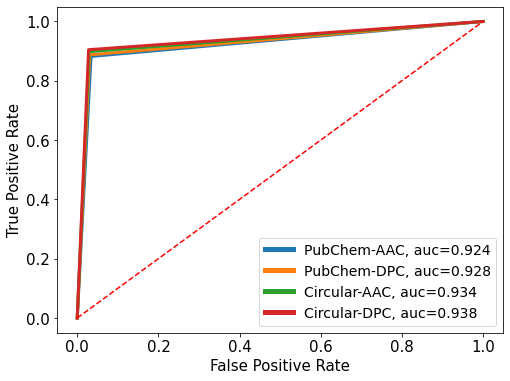

In [30]:
import matplotlib.pyplot as plt
plt.figure(figsize = (8,6))
plt.plot(best_auc_pubchem_aac[0],best_auc_pubchem_aac[1],label="{}, auc={:.3f}".format("PubChem-AAC",best_auc_pubchem_aac[2]),linewidth=3)
plt.plot(best_auc_pubchem_dpc[0],best_auc_pubchem_dpc[1],label="{}, auc={:.3f}".format("PubChem-DPC",best_auc_pubchem_dpc[2]),linewidth=3)
plt.plot(best_auc_circular_aac[0],best_auc_circular_aac[1],label="{}, auc={:.3f}".format("Circular-AAC",best_auc_circular_aac[2]),linewidth=3)
plt.plot(best_auc_circular_dpc[0],best_auc_circular_dpc[1],label="{}, auc={:.3f}".format("Circular-DPC",best_auc_circular_dpc[2]),linewidth=3)
# plt.title('Perbandingan Grafik ROC pada Variasi Penggunaan Fitur Protein', fontsize=15)
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate', fontsize=15)
plt.xlabel('False Positive Rate', fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
leg = plt.legend(loc="lower right", prop={'size': 14})
for legobj in leg.legendHandles:  
    legobj.set_linewidth(5.0)
plt.show()

In [33]:
res_all_combine = [res_all_pubchem_aac,res_all_pubchem_dpc,res_all_circular_aac,res_all_circular_dpc]
res_all_combine

[[[0.9519553072625698,
   0.9528491620111732,
   0.9512849162011173,
   0.9519553072625698,
   0.94590970049173],
  [0.8552278820375335,
   0.8739946380697051,
   0.8646112600536193,
   0.8820375335120644,
   0.8348993288590604],
  [0.8563758389261745,
   0.8478543563068921,
   0.8464566929133859,
   0.8382165605095542,
   0.8394062078272605],
  [0.9132669310965356,
   0.9213094670638148,
   0.9166177780557718,
   0.9239900727361876,
   0.9014936440487311],
  [0.8558014755197855,
   0.8607260726072609,
   0.8554376657824935,
   0.8595689092096669,
   0.8371467025572005]],
 [[0.9515083798882682,
   0.9555307262569832,
   0.9541899441340782,
   0.951731843575419,
   0.9474742959320519],
  [0.8699731903485255,
   0.8873994638069705,
   0.8766756032171582,
   0.8806970509383378,
   0.8523489932885906],
  [0.8439531859557867,
   0.851994851994852,
   0.8526727509778357,
   0.8380102040816326,
   0.8355263157894737],
  [0.9188964905885829,
   0.9282800483422087,
   0.923186286457064,
   0.92

In [34]:
res_pubchem_aac = pd.DataFrame(res_all_combine[0], index = ["Akurasi", "Recall", "Precision", "AUROC", "F-measure"]).transpose()
res_pubchem_dpc = pd.DataFrame(res_all_combine[1], index = ["Akurasi", "Recall", "Precision", "AUROC", "F-measure"]).transpose()
res_circular_aac = pd.DataFrame(res_all_combine[2], index = ["Akurasi", "Recall", "Precision", "AUROC", "F-measure"]).transpose()
res_circular_dpc = pd.DataFrame(res_all_combine[3], index = ["Akurasi", "Recall", "Precision", "AUROC", "F-measure"]).transpose()
res_pubchem_aac["Dataset"] = ["PubChem-AAC" for i in range(res_pubchem_aac.shape[0])]
res_pubchem_dpc["Dataset"] = ["PubChem-DPC" for i in range(res_pubchem_dpc.shape[0])]
res_circular_aac["Dataset"] = ["Circular-AAC" for i in range(res_circular_aac.shape[0])]
res_circular_dpc["Dataset"] = ["Circular-DPC" for i in range(res_circular_dpc.shape[0])]
res_combine = pd.concat([res_pubchem_aac,res_pubchem_dpc,res_circular_aac,res_circular_dpc], axis = 0)

<Figure size 720x576 with 0 Axes>

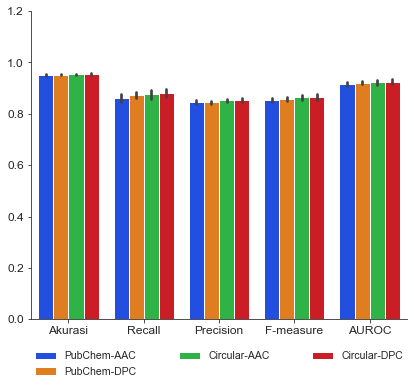

In [37]:
df_res = res_combine.copy()
df_res = pd.melt(df_res, id_vars=["Dataset"], value_vars=["Akurasi","Recall","Precision","F-measure","AUROC"])

import seaborn as sns
sns.set_style("ticks")
plt.figure(figsize = (10,8))
g = sns.catplot(x="variable", y="value", hue="Dataset", data=df_res, height=5, kind="bar", palette="bright", aspect = 1.2, legend = False, ci = "sd")
plt.legend(bbox_to_anchor=(0., -.2, 1., .102), loc='lower left', ncol=3, mode="expand", borderaxespad=0., frameon = False, prop={'size': 10.5})
g.set_xticklabels(fontsize=12)
g.set_yticklabels(fontsize=12)
g.set_xlabels("")
g.set_ylabels("")